In [27]:
#!/usr/bin/env python
# coding: utf-8

# In[ ]:


# import tempfile
import matplotlib.pyplot as plt
import pydicom
from pydicom.data import get_testdata_file
import cv2
import os
from skimage import morphology
import math
import numpy as np
from scipy import ndimage
from tqdm import tqdm
import glob as glob
import SimpleITK as sitk
import sys
from pydicom.encaps import encapsulate
from pydicom.uid import JPEG2000
from pydicom.pixel_data_handlers.util import apply_modality_lut
from imagecodecs import jpeg_encode
import imagecodecs
import random
from pydicom.uid import ExplicitVRLittleEndian
from imagecodecs import jpeg_encode
import imagecodecs
import pylibjpeg
import json
import copy
# # CT

# In[ ]:
def sorted_files(folder):
    ins=[]
    ser=[]
    f= sorted(glob.glob((folder + "/**/*.dcm"),recursive = True))

    for name in tqdm(f):
        try:
            ds = pydicom.dcmread(os.path.join(folder,name))
            temp = float(ds.InstanceNumber)
            temp1 = ds.SeriesInstanceUID
            ins.append(int(temp))
            ser.append(temp1)
        except:
            itkimage = sitk.ReadImage(os.path.join(folder,name))
            temp= float(itkimage.GetMetaData('0020|0013')) # instance number 
            temp1= itkimage.GetMetaData('0020|000e') #series instance UID 
            ins.append(int(temp))
            ser.append(temp1)
    series=np.unique(ser)
    files=[[x for sr,_,x in sorted(zip(ser,ins,f)) if sr==s] for s in series]
    return files

def get_scan(path):
    f= sorted_files(path)
    series=[]
    files=[]
    for i in tqdm (range (len(f))):
        img=[]
        file=[]
        for filename in f[i]:
            itkimage = sitk.ReadImage(os.path.join(path,filename))
            numpyImage = sitk.GetArrayFromImage(itkimage)
            img.append(numpyImage[0,:,:])
            file.append(filename)
        series.append(img)
        files.append(file)
    return series,files

def CT_blurred_sag(image,dicom_img,rows,columns):
    imagee = image>-800
#     #plt.imshow(imagee,'gray')
#     #plt.title("image greater than -400")
#     #plt.show()

    skull = image>1200
#     #plt.imshow(skull,'gray')
#     #plt.title("skull; image greater than 1000")
#     #plt.show()

    kernel = np.ones((30, 30), np.uint8)
    imagee = cv2.morphologyEx(imagee.astype(np.uint8), cv2.MORPH_CLOSE, kernel)
    imagee = ndimage.binary_fill_holes(imagee)
    imagee = imagee.astype(np.uint8)
    contours, hierarchy = cv2.findContours(imagee, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)    
    gray = np.zeros_like(imagee)
    gray = cv2.drawContours(gray, contours,-1, 255,-1 )
#     #plt.imshow(gray,'gray')
#     #plt.title("contours")
#     #plt.show()

    mid = int(image.shape[0]/2)

    gray = np.where((gray==255), 0, 255)
    gray[:,mid:] = 0
    gray1 = np.zeros_like(imagee)
    gray1 = cv2.drawContours(gray1, contours,-1, 255,10)
#     #plt.imshow(gray1,'gray')
#     #plt.title("contours2")
#     #plt.show()
    gray1[:,mid:] = 0
    gray=np.where((gray1==255), gray1, gray)
    gray=np.where((gray==255),1,0)

#     #plt.imshow(out,'gray')
#     #plt.title("out")
#     #plt.show()

    if np.min(image) == np.min(dicom_img) and np.max(image) == np.max(dicom_img):
#         print("equal")
        blurred_img = cv2.GaussianBlur(image, (101, 101), 400)
        out = np.where((gray==1), blurred_img, image)
        out = np.where(skull>0,image,out)
        out = out.astype(np.int16)
#         print(np.min(out),np.max(out))
    else: 
#         print("not equal")
        blurred_img = cv2.GaussianBlur(dicom_img, (101, 101), 50)
        out = np.where((gray==1), blurred_img, dicom_img)
        out = np.where(skull>0,dicom_img,out)
        out = out.astype(np.int16)
#         print(np.min(out),np.max(out))
        
#     for i in range(np.shape(out)[0]):
#         if not np.any(temp[i]):
#             out[i]=np.multiply(out[i],0)
#             out = out.astype(np.int16)
    
    return out
    
def CT_blurred_axial(image, dicom_img, rows, columns):
    imagee = image>-50
#     #plt.imshow(imagee,'gray')
#     #plt.title("image greater than -50")
#     #plt.show()
    
    skull = image>500
#     #plt.imshow(skull,'gray')
#     #plt.title("skull; image greater than 500")
#     #plt.show()
    
    kernel = np.ones((30, 30), np.uint8)
    imagee = cv2.morphologyEx(imagee.astype(np.uint8), cv2.MORPH_CLOSE, kernel)
    imagee = ndimage.binary_fill_holes(imagee)
    imagee = imagee.astype(np.uint8)
    contours, hierarchy = cv2.findContours(imagee, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)    
    gray = np.zeros_like(imagee)
    gray = cv2.drawContours(gray, contours,-1, 255,-1 )
#     #plt.imshow(gray,'gray')
#     #plt.title("contours")
#     #plt.show()
    gray = np.where((gray==255), 0, 255)
    gray[300:,:] = 0
    gray1 = np.zeros_like(imagee)
    gray1 = cv2.drawContours(gray1, contours,-1, 255,7)
#     #plt.imshow(gray1,'gray')
#     #plt.title("contours2")
#     #plt.show()
    gray1[300:,:] = 0
    gray=np.where((gray1==255), gray1, gray)
    gray=np.where((gray==255),1,0)
    
    if np.min(image) == np.min(dicom_img) and np.max(image) == np.max(dicom_img):
#         print("equal")
        blurred_img = cv2.GaussianBlur(image, (101, 101), 400)
        out = np.where((gray==1), blurred_img, image)
        out = np.where(skull>0,image,out)
        out = out.astype(np.int16)
#         print(np.min(out),np.max(out))
        return out
    else: 
#         print("not equal")
        blurred_img = cv2.GaussianBlur(dicom_img, (101, 101), 50)
        out = np.where((gray==1), blurred_img, dicom_img)
        out = np.where(skull>0,dicom_img,out)
        out = out.astype(np.int16)
#         print(np.min(out),np.max(out))
        return out
        
def CT_blurred_coronal(image, dicom_img, rows, columns):

    imagee = image>-400
#     #plt.imshow(imagee,'gray')
#     #plt.title("image greater than -400")
#     #plt.show()

    skull = image>1000
#     #plt.imshow(skull,'gray')
#     #plt.title("skull; image greater than 1000")
#     #plt.show()

    kernel = np.ones((30, 30), np.uint8)
    imagee = cv2.morphologyEx(imagee.astype(np.uint8), cv2.MORPH_CLOSE, kernel)
    imagee = ndimage.binary_fill_holes(imagee)
    imagee = imagee.astype(np.uint8)
    contours, hierarchy = cv2.findContours(imagee, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)    
    gray = np.zeros_like(imagee)
    gray = cv2.drawContours(gray, contours,-1, 255,-1 )
#     #plt.imshow(gray,'gray')
#     #plt.title("contours")
#     #plt.show()

    mid = int(image.shape[0]/2)

    gray = np.where((gray==255), 0, 255)
    gray[:200,:] = 0
    gray1 = np.zeros_like(imagee)
    gray1 = cv2.drawContours(gray1, contours,-1, 255,10)
#     #plt.imshow(gray1,'gray')
#     #plt.title("contours2")
#     #plt.show()
    gray1[:200,:] = 0
    gray=np.where((gray1==255), gray1, gray)
    gray=np.where((gray==255),1,0)

    if np.min(image) == np.min(dicom_img) and np.max(image) == np.max(dicom_img):
#         print("equal")
        blurred_img = cv2.GaussianBlur(image, (101, 101), 400)
        out = np.where((gray==1), blurred_img, image)
        out = np.where(skull>0,image,out)
        out = out.astype(np.int16)
#         print(np.min(out),np.max(out))
    else: 
#         print("not equal")
        blurred_img = cv2.GaussianBlur(dicom_img, (101, 101), 50)
        out = np.where((gray==1), blurred_img, dicom_img)
        out = np.where(skull>0,dicom_img,out)
        out = out.astype(np.int16)
#         print(np.min(out),np.max(out))
    
    return out

def predictions_ct(path, output):
    if not os.path.exists(output):
        os.makedirs(output)
    output_list= []
    classUID = []
    annotations=[]
#     start_files = timeit.default_timer()
    scan_series,filenames=get_scan(path)
#     stop_files = timeit.default_timer()
#     print("time for files: ", stop_files - start_files)
    
#     start_ai = timeit.default_timer()
    for j in tqdm(range(len(scan_series))):
        scan, names = scan_series[j],filenames[j]
        scan=np.asarray(scan)
        # print(scan.shape[0])
        # print("no.of files: ",len(names))
        dcmData = pydicom.dcmread(os.path.join(path,names[0]))
        
#         #plt.imshow(dcmData.pixel_array,'gray')
#         #plt.show()
        
        axial  =  np.array([1., 0., 0., 0., 1., 0.])
#         sagittal = np.array([-1, 0., 0., 0., 0., -1.])
        sagittal = np.array([0, 1., 0., 0., 0., -1.])
        coronal = np.array([1., 0., 0., 0., 0., -1.])
        if (0x0020,0x0037) in dcmData:
            a = (np.around(dcmData.ImageOrientationPatient, 0))
#             print(a)
            if (a == axial).all():
#                 print("in axial")
                for i in range(scan.shape[0]):
                    name = names[i]
                    img = scan[i, :, :]
#                     print("max and min of scan sitk ",np.min(img),np.max(img))
                    dcmData = pydicom.dcmread(os.path.join(path,name)) ##read file to change it's pixel data to anonymized
                    dicom_img = dcmData.pixel_array
#                     print("max and min of input dicom ",np.min(dcmData.pixel_array),np.max(dcmData.pixel_array))
                    r= dcmData.Rows
                    c=dcmData.Columns
                    out= CT_blurred_axial(img,dicom_img,r,c)
                    out = out.astype(np.int16)
                    dcmData.file_meta.TransferSyntaxUID= '1.2.840.10008.1.2.1'
                    dcmData.PixelData = out.tobytes()
#                     print("max and min of output ",np.min(dcmData.pixel_array),np.max(dcmData.pixel_array))
                    
#                     #plt.imshow(dcmData.pixel_array,'gray')
#                     #plt.title("axial blurred")
#                     #plt.show()
                    _, tail = os.path.split(name)
                    des_path = os.path.join(output, tail)
                    dcmData.save_as(des_path) ##save file in anonym folder
                    classUID.append(str(dcmData.SOPInstanceUID))
                    output_list.append(des_path)
                    annotations.append(None) 
            elif (a==sagittal).all():
#                 print("in sagittal")
                for i in range(scan.shape[0]):
                    name = names[i]
                    img = scan[i, :, :]
                    dcmData = pydicom.dcmread(os.path.join(path,name)) ##read file to change it's pixel data to anonymized
                    r= dcmData.Rows
                    c=dcmData.Columns
                    dicom_img = dcmData.pixel_array

                    out = CT_blurred_sag(img,dicom_img,r,c)
                        
                    out = out.astype(np.int16)
                    dcmData.file_meta.TransferSyntaxUID= '1.2.840.10008.1.2.1'
                    dcmData.PixelData = out.tobytes()
                    
#                     #plt.imshow(dcmData.pixel_array,'gray')
#                     #plt.title("sagittal blurred")
#                     #plt.show()
                    _, tail = os.path.split(name)
                    des_path = os.path.join(output, tail)
                    dcmData.save_as(des_path) ##save file in anonym folder
                    classUID.append(str(dcmData.SOPInstanceUID))
                    output_list.append(des_path)
                    annotations.append(None) 
            elif (a==coronal).all():
#                 print("in coronal")
                for i in range(scan.shape[0]):
                    name = names[i]
                    img = scan[i, :, :]
                    dcmData = pydicom.dcmread(os.path.join(path,name))
                    dicom_img = dcmData.pixel_array
#                     print("max and min of input dicom ",np.min(dcmData.pixel_array),np.max(dcmData.pixel_array))
                    r= dcmData.Rows
                    c=dcmData.Columns
                    out= CT_blurred_coronal(img,dicom_img,r,c)
                    out = out.astype(np.int16)
                    dcmData.file_meta.TransferSyntaxUID= '1.2.840.10008.1.2.1'
                    dcmData.PixelData = out.tobytes()
#                     print("max and min of output ",np.min(dcmData.pixel_array),np.max(dcmData.pixel_array))
                    
#                     #plt.imshow(dcmData.pixel_array,'gray')
#                     #plt.title("coronal blurred")
#                     #plt.show()
                    _, tail = os.path.split(name)
                    des_path = os.path.join(output, tail)
                    dcmData.save_as(des_path) ##save file in anonym folder
                    classUID.append(str(dcmData.SOPInstanceUID))
                    output_list.append(des_path)
                    annotations.append(None) 
            else:
                for i in range(scan.shape[0]):
                    name = names[i]
                    img = scan[i, :, :]
                    dcmData = pydicom.dcmread(os.path.join(path,name)) 
                    _, tail = os.path.split(name)
                    des_path = os.path.join(output, tail)
                    dcmData.save_as(des_path) 
                    classUID.append(str(dcmData.SOPInstanceUID))
                    output_list.append(des_path)
                    annotations.append(None) 
        else:
#             print("save as it is")
#             print(j)
            for i in range(scan.shape[0]):
#                 print(j)
                name = names[i]
                img = scan[i, :, :]
                dcmData = pydicom.dcmread(os.path.join(path,name)) 
                _, tail = os.path.split(name)
                des_path = os.path.join(output, tail)
                dcmData.save_as(des_path) 
                classUID.append(str(dcmData.SOPInstanceUID))
                output_list.append(des_path)
                annotations.append(None) 

    mimeType = "application/dicom"
    mimeType = []
    for i in range(len(output_list)):
        mimeType.append("application/dicom")
    image=[]
    print("in AI",len(classUID))
    for i in range(len(classUID)):
        image.append(None)
    recommendation_string = {"finding": "dummy finding","conclusion":"dummy conclusion","recommendation":"dummy recommendation"} 
    all_result={"output_list":output_list, "classUID":classUID, "mimeType":mimeType, "recommendation_string": recommendation_string,"annotations":annotations,"image":image}
    #with open(path+"/values.json", "w") as outfile:
        #json.dump(all_result, outfile)
#     print(recommendation_string)
    return all_result

# # CBCT 

# In[ ]:
def dcm_image(filename): 
    itkimage = sitk.ReadImage(filename)
    numpyImage = sitk.GetArrayFromImage(itkimage)
    ins = float(itkimage.GetMetaData('0020|0013'))
    return numpyImage, ins

def get_full_scan(folder_path):
    files_List = glob.glob(folder_path + '/**/*.dcm', recursive=True)
    try:
        ds = pydicom.dcmread(files_List[0])
        rows = ds.Rows
        cols = ds.Columns
        mn = 1000
        mx = 0
        for file in tqdm(files_List):
            ds = pydicom.dcmread(file)
            mn = np.min([mn, int(ds.InstanceNumber)])
            mx = np.max([mx, int(ds.InstanceNumber)])        
    except:
        itkimage = sitk.ReadImage(files_List[0])
        rows = int(itkimage.GetMetaData('0028|0010'))
        cols = int(itkimage.GetMetaData('0028|0011'))
        mn = 1000
        mx = 0
        for file in tqdm(files_List):
            itkimage = sitk.ReadImage(file)
            mn = np.min([mn, int(itkimage.GetMetaData('0020|0013'))])
            mx = np.max([mx, int(itkimage.GetMetaData('0020|0013'))])
    full_scan = np.ndarray(shape=(mx - mn + 1, rows, cols), dtype=float, order='F')
    new_list = np.ndarray(shape=(mx - mn + 1), dtype=object)
    for file in tqdm(files_List):
        img, n = dcm_image(file)
        n = int(n)
        full_scan[n - mn, :, :] = img[0, :, :]
        new_list[n-mn] = file
    return full_scan,new_list

def get_normalized(scan,mn,mx):
    scann = copy.copy(scan)
    try:
        mn = max(mn,np.amin(scann))
        mx = min(mx,np.amax(scann))
    except:
        print("in except")
        scann2 = copy.copy(scan)
        scann2 = scann2[:scann2.shape[0]-1,:,:]
        mn = max(mn,np.amin(scann2))
        mx = min(mx,np.amax(scann2))
    np.clip(scann, mn, mx, out=scann)
    d = mx - mn
    scann = (scann-mn)/d
    return scann

def dynamic_windowing(scan):
    counts,bins,bars = plt.hist(scan.flatten())
    #plt.close()
    if bins[-1]>3200:
        a  = 2
#         print("Type 2")
        scan = get_normalized(scan, -800, 2500)
    else:
        scan = scan
        a = 1
    return scan,a

#         counts = sorted(counts)
# #         c1 = counts[-1]/counts[-2]

#         if counts[0]<7000:
        
#             print('Type 1')
#             a=1
#             scan = get_normalized(scan,-250,1800)
#         else:
#             a=3
#             print('Type 3')
#             scan = get_normalized(scan,-250,3000)
#     return scan,a

def blur_1(image, prev = 0, s = 0):
    gray = np.zeros((image.shape[0], image.shape[1]) , dtype=int)
    for i in range(gray.shape[0]):
        for j in range(gray.shape[1]):
            if image[i,j] > -300 and image[i,j] < 500:
                gray[i,j] = 1
#         #plt.imshow(gray , cmap = 'gray')
#         #plt.title("org gray")
#         #plt.show()
#         print(np.min(gray), np.max(gray))


    ker1 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(1,1))
    ker2 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
    gray = cv2.morphologyEx(np.float32(gray), cv2.MORPH_CLOSE, ker1)
    gray = cv2.morphologyEx(np.float32(gray), cv2.MORPH_CLOSE, ker2)
#     #plt.imshow(gray , cmap = 'gray')
#     #plt.title("gray after closing")
#     #plt.show()
    gray = gray>0
    gray = morphology.remove_small_objects(gray, min_size=200)
#     #plt.imshow(gray , cmap = 'gray')
#     #plt.title("after removing small objects")
#     #plt.show()
    gray = gray.astype(np.uint8)
    kernel = np.ones((30, 30), np.uint8)
    gray = cv2.morphologyEx(gray, cv2.MORPH_CLOSE, kernel)
    gray = gray.astype(np.uint8)
#     #plt.imshow(gray , cmap = 'gray')
#     #plt.title("closing")
#     #plt.show()
    contours, hierarchy = cv2.findContours(gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    gray = cv2.drawContours(gray, contours,-1, 255, 10)
#     #plt.imshow(gray , cmap = 'gray')
#     #plt.title("contours")
#     #plt.show()
    gray[300:,:] = 0
#     #plt.imshow(gray, cmap ='gray')
#     #plt.show()
    seg = gray
    seg = np.where((seg==255),seg,0)
    z=0
    if not s==0:
        diff = np.subtract(seg,prev)
        diff = diff>1
        xx = int((diff.shape[1])/2)
        diff[:,0:(xx-100)] =0
        diff[:,(xx+100):] = 0
        diff = morphology.remove_small_objects(diff, min_size=500)
        if np.any(diff):
            for l in range(diff.shape[1]):
                for j in range(diff.shape[0]):
                    if diff[j,l]==True:
                        if np.any(prev[(j-10):(j+10),l]):
                            diff[j,l] = False
            seg = np.where((diff==True),0,seg)
            z=1

    blurred_img = cv2.GaussianBlur(image, (101, 101), 400)
    out = np.where((seg==255), blurred_img, image)
#     #plt.imshow(out,'gray')
#     #plt.show()
    out = out.astype(np.int16)
#         #plt.imshow(out,'gray')
#         #plt.show()
    if z==0:
        return out , seg
    else:
        return out, prev

    
def blur_2(img, ds,low, high, prev = 0, s=0):
    # print("low n high: ",low, high)
    dcm = img*np.max(ds.pixel_array) #*2048#*np.max(scan)
#     #plt.imshow(dcm,'gray')
#     #plt.show()
    # print(np.min(dcm),np.max(dcm))
    gray = np.zeros((dcm.shape[0], dcm.shape[1]) , dtype=int)
    for i in range(gray.shape[0]):
        for j in range(gray.shape[1]):
            if dcm[i,j] > low and dcm[i,j] < high:
                gray[i,j] = 1
#     #plt.imshow(gray , cmap = 'gray')
#     #plt.title("org gray")
#     #plt.show()
    #         print(np.min(gray), np.max(gray))

    ker1 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(1,1))
    ker2 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
    gray = cv2.morphologyEx(np.float32(gray), cv2.MORPH_CLOSE, ker1)
    gray = cv2.morphologyEx(np.float32(gray), cv2.MORPH_CLOSE, ker2)
    #     #plt.imshow(gray , cmap = 'gray')
    #     #plt.title("gray after closing")
    #     #plt.show()
    gray = gray>0
    gray = morphology.remove_small_objects(gray, min_size=200)
    #     #plt.imshow(gray , cmap = 'gray')
    #     #plt.title("after removing small objects")
    #     #plt.show()
    gray = gray.astype(np.uint8)
    kernel = np.ones((30, 30), np.uint8)
    gray = cv2.morphologyEx(gray, cv2.MORPH_CLOSE, kernel)
    gray = gray.astype(np.uint8)
    #     #plt.imshow(gray , cmap = 'gray')
    #     #plt.title("closing")
    #     #plt.show()
    contours, hierarchy = cv2.findContours(gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    gray = cv2.drawContours(gray, contours,-1, 255, 10)
    #     #plt.imshow(gray , cmap = 'gray')
    #     #plt.title("contours")
    #     #plt.show()
    gray[400:,:] = 0
#     #plt.imshow(gray, cmap ='gray')
#     #plt.show()

    seg = gray
    seg = np.where((seg==255),seg,0)
    z=0
    if not s==0:
        diff = np.subtract(seg,prev)
        diff = diff>1
        xx = int((diff.shape[1])/2)
        diff[:,0:(xx-100)] =0
        diff[:,(xx+100):] = 0
        diff = morphology.remove_small_objects(diff, min_size=500)
        if np.any(diff):
            for l in range(diff.shape[1]):
                for j in range(diff.shape[0]):
                    if diff[j,l]==True:
                        if np.any(prev[(j-10):(j+10),l]):
                            diff[j,l] = False
            seg = np.where((diff==True),0,seg)
            z=1

    blurred_img = cv2.GaussianBlur(ds.pixel_array, (101, 101), 800)
    
    out = np.where((seg==255), blurred_img, ds.pixel_array)
#     #plt.imshow(out,'gray')

    out = out.astype(np.int16)

#     print(np.min(ds.pixel_array),np.max(ds.pixel_array))
#     ds.PixelData = out.tobytes()

#     #plt.imshow(ds.pixel_array,'gray')
#     #plt.title("bytes")
#     #plt.show()

#     print(np.min(ds.pixel_array),np.max(ds.pixel_array))

    if z==0:
        return out , seg
    else:
        return out, prev   
    

# from skimage.metrics import structural_similarity

# def signaltonoise(a, axis=0, ddof=0):
#     a = np.asanyarray(a)
#     m = a.mean(axis)
#     sd = a.std(axis=axis, ddof=ddof)
#     return np.where(sd == 0, 0, m/sd)


def prediction_CBCT_1(scann, names, output_folder):
    output_list= []
    classUID = []
    annotations=[]

    iscan = copy.copy(scann)
    oscan = copy.copy(scann)    
    
    for i in tqdm(range(scann.shape[0])):
        name = names[i]
        img = scann[i, :, :]

        dcmData = pydicom.dcmread(name)
        dicom_img = dcmData.pixel_array #for calculating parameters
        iscan[i] = dicom_img

        if i == 0:
            out, prev_img = blur_1(img)
        else:
            out, prev_img = blur_1(img, prev_img, s=1)
#             print(np.min(out),np.max(out))    
#             #plt.imshow(out,'gray')
#             #plt.title("after ct_blur")
#             #plt.show()

        out = out.astype(np.int16)
        oscan[i] = out
#             #plt.imshow(out,'gray')
#             #plt.title("after int16")
#             #plt.show()
#             print("after blue and np16: ", np.min(out),np.max(out))

#             dcmData = pydicom.dcmread(name)
        outbytes = out.tobytes()

#             print("bytes min and maximum",np.min(outbytes.pixel_array),np.max(outbytes.pixel_array))
        dcmData.PixelData = outbytes

        # print("pixel data min and maximum",np.min(dcmData.pixel_array),np.max(dcmData.pixel_array))
        # #plt.imshow(dcmData.pixel_array,'gray')
        # #plt.title("bytes")
        # #plt.show()

        _, tail = os.path.split(name)
        des_path = os.path.join(output_folder, tail)
        dcmData.file_meta.TransferSyntaxUID= '1.2.840.10008.1.2.1'
        dcmData.save_as(des_path)

        classUID.append(str(dcmData.SOPInstanceUID))
        output_list.append(des_path)
        annotations.append(None)    
    
    # isnr = signaltonoise(iscan, axis=None, ddof=0)
    # osnr = signaltonoise(oscan,axis=None, ddof=0)
    # (ss, dd) = structural_similarity(iscan, oscan, full=True)

    # print(isnr, osnr, ss)
    
    return output_list, classUID, annotations

def prediction_CBCT_2(scann, names, output_folder):
    
    output_list= []
    classUID = []
    annotations=[]    
    
    iscan = copy.copy(scann)
    oscan = copy.copy(scann)
    
    for i in tqdm(range(scann.shape[0])):
        name = names[i]
        img = scann[i, :, :]
        low = 350
        high = 2000
        dcmData = pydicom.dcmread(name)
        if dcmData.file_meta.TransferSyntaxUID == "1.2.840.10008.1.2.4.70":
            dcmData.decompress('pylibjpeg')
            low = 250
            high = 3000
            
        dicom_img = dcmData.pixel_array
        iscan[i] = dicom_img
        
        if i == 0:
            out, prev_img = blur_2(img, dcmData, low, high)
        else:
            out, prev_img = blur_2(img, dcmData, low, high, prev_img, s=1)
#             print(np.min(out),np.max(out))    
#             #plt.imshow(out,'gray')
#             #plt.title("after ct_blur")
#             #plt.show()

        out = out.astype(np.int16)
        oscan[i] = out
#             #plt.imshow(out,'gray')
#             #plt.title("after int16")
#             #plt.show()
#             print("after blue and np16: ", np.min(out),np.max(out))

#             dcmData = pydicom.dcmread(name)
        outbytes = out.tobytes()

#             print("bytes min and maximum",np.min(outbytes.pixel_array),np.max(outbytes.pixel_array))
        dcmData.PixelData = outbytes

        # print("pixel data min and maximum",np.min(dcmData.pixel_array),np.max(dcmData.pixel_array))
        # #plt.imshow(dcmData.pixel_array,'gray')
        # #plt.title("bytes")
        # #plt.show()

        _, tail = os.path.split(name)
        des_path = os.path.join(output_folder, tail)
        dcmData.file_meta.TransferSyntaxUID= '1.2.840.10008.1.2.1'
        dcmData.save_as(des_path)
        
#         test_ds = pydicom.dcmread(des_path)
#         test_s = test_ds.pixel_array
#         #plt.imshow(test_s,'gray')
#         #plt.title("read output")
#         #plt.show()
        
        classUID.append(str(dcmData.SOPInstanceUID))
        output_list.append(des_path)
        annotations.append(None)
    
    # isnr = signaltonoise(iscan, axis=None, ddof=0)
    # osnr = signaltonoise(oscan,axis=None, ddof=0)
    # (ss, dd) = structural_similarity(iscan, oscan, full=True)

    # print(isnr, osnr, ss)
    
    return output_list, classUID, annotations

def predictions_cbct(input_folder, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    files_list = sorted(glob.glob((input_folder+ "/**/*.dcm"),recursive = True))
    
    initialdata = pydicom.dcmread(files_list[0])
    mode = str(initialdata.Modality)
    # start_AI = timeit.default_timer()
    if (mode=='CT') or (mode=='ct'):
        i = 0
        # start_files = timeit.default_timer()
        scan, names = get_full_scan(input_folder)
        # stop_files = timeit.default_timer()
        # print("time for reading files: ", (stop_files - start_files))
        
        inscan = copy.copy(scan)
        scann,a = dynamic_windowing(inscan)
        
        if a == 1:
            # print("Type 1, org alg")
            output_list, classUID, annotations = prediction_CBCT_1(scan, names, output_folder)
        elif a == 2:
            # print("Type 2, improv alg")
            output_list, classUID, annotations = prediction_CBCT_2(scann, names, output_folder)
        

#             i = i + 1
    # stop_ai = timeit.default_timer()
    # print("Time taken by AI: ", stop_ai - start_AI)
    

#     mimeType = "application/dicom"
    mimeType = []
    for i in range(len(output_list)):
        mimeType.append("application/dicom")
    image=[]
    print("in AI",len(classUID))
    for i in range(len(classUID)):
        image.append(None)
    recommendation_string = {"finding": "dummy finding","conclusion":"dummy conclusion","recommendation":"dummy recommendation"} 
    all_result={"output_list":output_list, "classUID":classUID, "mimeType":mimeType,"annotations":annotations, "recommendation_string": recommendation_string,"image":image}
    #with open(input_folder+"/values.json", "w") as outfile:
        #json.dump(all_result, outfile)
    # print(recommendation_string)
        

    return all_result

## MRI
def dynamic_windowing_mri(scan, scan_seriesi):
    counts,bins,bars = plt.hist(scan.flatten())
    
#     print(bins[-1])
    #plt.close()
    if bins[-1]>3200:
        a  = 2
#         print("Type 2")
        scan = get_normalized(scan, -800, 2500)
    elif bins[-1]>350:
        a = 3
#         print("Type 3")
        scan = get_normalized(scan, 5, 100)
    else:
        scan = get_normalized(scan, np.min(scan), np.max(scan))
        a = 1
    return scan,a

def MRI_blurred_sag(image):

    rows=image.shape[1]
    columns=image.shape[0]
    head = image>100
    skull = image>500
    ROI=np.logical_xor(head,skull)
    kernel = np.ones((30, 30), np.uint8)
    imagee = cv2.morphologyEx(ROI.astype(np.uint8), cv2.MORPH_CLOSE, kernel)
    imagee = ndimage.binary_fill_holes(imagee)
    imagee = imagee.astype(np.uint8)
    contours, hierarchy = cv2.findContours(imagee, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    gray = np.zeros_like(imagee)
    gray = cv2.drawContours(gray, contours,0, 255,1 )
    ##plt.imshow(gray,'gray')
    ##plt.show()
    temp=gray.copy()
    temp=np.where((temp==255),1,0)
    variable=int(temp.shape[1]/2)
    temp[:,variable:] = 0
    ##plt.imshow(temp,'gray')
    ##plt.show()
    
    r=[[random.randint(-250,500) for i in range(rows)] for j in range(columns)]
    r=np.asarray(r)
    blurred_img= np.multiply(temp,r)
    out = np.where((temp==1), blurred_img, image)

    dum = copy.copy(image)
    dum[:,:] = 0
    input_skin = np.where(temp==1, image, dum)
    #plt.imshow(input_skin,'gray')
    #plt.show()
    
    dum2 = copy.copy(out)
    dum2[:,:] = 0
    output_skin = np.where(temp==1, out, dum2)
    #plt.imshow(output_skin,'gray')
    #plt.show()
    return out, input_skin, output_skin

def MRI_blurred_axial(image):
    rows=image.shape[1]
    columns=image.shape[0]
    #print(rows,columns)
    #print(image.shape)
    head = image>100
    skull = image>500
    ROI=np.logical_xor(head,skull)
    kernel = np.ones((30, 30), np.uint8)
    imagee = cv2.morphologyEx(ROI.astype(np.uint8), cv2.MORPH_CLOSE, kernel)
    imagee = ndimage.binary_fill_holes(imagee)
    imagee = imagee.astype(np.uint8)
    contours, hierarchy = cv2.findContours(imagee, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    gray = np.zeros_like(imagee)
    gray = cv2.drawContours(gray, contours,0, 255,1 )
    ##plt.imshow(gray,'gray')
    ##plt.show()
    temp=gray.copy()
    temp=np.where((temp==255),1,0)
    variable=int((temp.shape[0])/2)
    temp[variable:,:] = 0
    ##plt.imshow(temp,'gray')
    ##plt.show()

    r=[[random.randint(-250,500) for i in range(rows)] for j in range(columns)]
    r=np.asarray(r)
    #print(r.shape)
    blurred_img= np.multiply(temp,r)
    out = np.where((temp==1), blurred_img, image)
    
    dum = copy.copy(image)
    dum[:,:] = 0
    input_skin = np.where(temp==1, image, dum)
    #plt.imshow(input_skin,'gray')
    #plt.show()
    
    dum2 = copy.copy(out)
    dum2[:,:] = 0
    output_skin = np.where(temp==1, out, dum2)
    #plt.imshow(output_skin,'gray')
    #plt.show()
    return out, input_skin, output_skin

def MRI_blurred_coronal(image):

    rows=image.shape[1]
    columns=image.shape[0]
    #print(rows,columns)
    #print(image.shape)
    head = image>100
    skull = image>500
    ROI=np.logical_xor(head,skull)
    kernel = np.ones((30, 30), np.uint8)
    imagee = cv2.morphologyEx(ROI.astype(np.uint8), cv2.MORPH_CLOSE, kernel)
    imagee = ndimage.binary_fill_holes(imagee)
    imagee = imagee.astype(np.uint8)
    contours, hierarchy = cv2.findContours(imagee, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    gray = np.zeros_like(imagee)
    gray = cv2.drawContours(gray, contours,0, 255,1 )
    ##plt.imshow(gray,'gray')
    ##plt.show()
    temp=gray.copy()
    temp=np.where((temp==255),1,0)
    ##plt.imshow(temp,'gray')
    ##plt.show()
   
    r=[[random.randint(-250,500) for i in range(rows)] for j in range(columns)]
    r=np.asarray(r)
    
    blurred_img= np.multiply(temp,r)
    out = np.where((temp==1), blurred_img, image)
    
    dum = copy.copy(image)
    dum[:,:] = 0
    input_skin = np.where(temp==1, image, dum)
    #plt.imshow(input_skin,'gray')
    #plt.show()
    
    dum2 = copy.copy(out)
    dum2[:,:] = 0
    output_skin = np.where(temp==1, out, dum2)
    #plt.imshow(output_skin,'gray')
    #plt.show()
    return out, input_skin, output_skin

def predictions_mri_head(path, output_folder):
    print("in head")
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    output_list= []
    classUID = []
    annotations=[]        
    scan_series,filenames = get_scan(path)
    iskin = []
    oskin = []
    
    iscan = copy.copy(scan_series)
    oscan = copy.copy(scan_series)
    
    for j in tqdm(range(len(scan_series))):
        scan, names = scan_series[j],filenames[j]
        scan=np.asarray(scan)
        dcmData = pydicom.dcmread(os.path.join(path,names[0]))
        if (dcmData.PhotometricInterpretation == "RGB" ):
#             print("rgb")
            for i in range(scan.shape[0]):
                name = names[i]
                img = scan[i, :, :]
                dcmData = pydicom.dcmread(os.path.join(path,name)) 
                
                _, tail = os.path.split(name)
                des_path = os.path.join(output_folder, tail)
                dcmData.save_as(des_path) 
                classUID.append(str(dcmData.SOPInstanceUID))
                output_list.append(des_path) 
                annotations.append(None)
        elif (dcmData.PhotometricInterpretation == "rgb"):
#             print("rgb")
            for i in range(scan.shape[0]):
                name = names[i]
                img = scan[i, :, :]
                dcmData = pydicom.dcmread(os.path.join(path,name)) 
                
                _, tail = os.path.split(name)
                des_path = os.path.join(output_folder, tail)
                dcmData.save_as(des_path) 
                classUID.append(str(dcmData.SOPInstanceUID))
                output_list.append(des_path) 
                annotations.append(None)
        else:
#             print("mono")
            axial  =  np.array([1., 0., 0., 0., 1., 0.])
            #sagittal= np.array([-1., 0., 0., 0., 0., -1.])
            sagittal= np.array([0., 1., 0., 0., 0., -1.])
            coronal= np.array([1., 0., 0., 0., 0., -1.])
            if (0x0020,0x0037) in dcmData:
                a = (np.around(dcmData.ImageOrientationPatient, 0))
    #             print("a",a)
    #             print("scan shape",scan.shape[0])
                image= scan#[20,:,:]
                try:
                    histogram, bin_edges = np.histogram(image, bins=256)
                    check=bin_edges[-1]
                except:
    #                 print("here in except for ", j)
                    image = []
                    for i in range(len(scan_series[j])-1):
                        image.append(np.asarray(scan_series[j][i]))
                    histogram, bin_edges = np.histogram(image, bins=256)
                    check=bin_edges[-1] 

                if ((a == axial).all()) and check>1000 :
    #                 print("axial")
    #                 print(j)
                    #continue
                    iiskin = []
                    ooskin = []
                    for i in range(scan.shape[0]):
                        name = names[i]
                        img = scan[i, :, :]
                        dcmData = pydicom.dcmread(os.path.join(path,name)) ##read file to change it's pixel data to anonymized
                        # c= dcmData.Rows
                        # r=dcmData.Columns
                        dicom_img = dcmData.pixel_array
                        out,input_skin, output_skin = MRI_blurred_axial(img)
                        oscan[j][i] = out
                        iiskin.append(input_skin)
                        ooskin.append(output_skin)
                        #out = out.astype(np.int16)
                        #print(dicom_img.dtype)
                        out1 = out.astype(dicom_img.dtype)
                        #print(out.shape)
                        dcmData.file_meta.TransferSyntaxUID= '1.2.840.10008.1.2.1'
                        dcmData.PixelData = out1.tobytes()
                        '''
                        #plt.imshow(dcmData.pixel_array,'gray')
                        #plt.title("axial blurred")
                        #plt.show()

                        #plt.imshow(out, 'gray')
                        #plt.title("axial blurred OUT")
                        #plt.show()
                        '''
                        _, tail = os.path.split(name)
                        des_path = os.path.join(output_folder, tail)
                        dcmData.save_as(des_path) ##save file in anonym folder


                        classUID.append(str(dcmData.SOPInstanceUID))
                        output_list.append(des_path)
                        annotations.append(None)
                    iskin.append(iiskin)
                    oskin.append(ooskin)
                elif ((a==sagittal).all()) and check>1000:
    #                     print(j)
    #                     print("sag")
                       # continue
                        iiskin = []
                        ooskin = []
                        for i in range(scan.shape[0]):
                            name = names[i]
                            img = scan[i, :, :]
                            dcmData = pydicom.dcmread(os.path.join(path,name)) ##read file to change it's pixel data to anonymized
                            #print(dcmData.file_meta.TransferSyntaxUID)
                            dicom_img = dcmData.pixel_array
                            # r= dcmData.Rows
                            # c=dcmData.Columns
                            if i == 0:
                                out = img
                                oscan[j][i] = out
                            else:
                                out, input_skin, output_skin = MRI_blurred_sag(img)
                                iiskin.append(input_skin)
                                ooskin.append(output_skin)
                                oscan[j][i] = out
                            #out = out.astype(np.int16)
                            out = out.astype(dicom_img.dtype)
                            ##plt.imshow(out,'gray')
                            ##plt.show()

                            dcmData.file_meta.TransferSyntaxUID= '1.2.840.10008.1.2.1'
                            #dcmData.pixel_array = out
                            dcmData.PixelData = out.tobytes()
                            #dcmData.PixelData = out.tostring()
                            #dcmData.BitsAllocated = 
                            #dcmData.PixelRepresentation = 1
                            '''
                            #plt.imshow(dcmData.pixel_array,'gray')
                            #plt.title("sagittal blurred")
                            #plt.show()

                            #plt.imshow(out, 'gray')
                            #plt.title("sagittal blurred OUT")
                            #plt.show()
                            '''
                            _, tail = os.path.split(name)
                            des_path = os.path.join(output_folder, tail)
                            dcmData.save_as(des_path) ##save file in anonym folder

                            classUID.append(str(dcmData.SOPInstanceUID))
                            output_list.append(des_path)
                            annotations.append(None)
                        iskin.append(iiskin)
                        oskin.append(ooskin)
                elif ((a==coronal).all()) and (scan.shape[0]>100) and  check>1000:
    #                     print(j)
    #                     scan.shape[0]
    #                     print("coronal")
                        #continue
                        iiskin = []
                        ooskin = []
                        for i in range(scan.shape[0]):
    #                     for i in range(50): #distorting the boundary for only the front of the coronal scan i.e the face part
                            if i<50:
                                name = names[i]
                                img = scan[i, :, :]
                                dcmData = pydicom.dcmread(os.path.join(path,name)) ##read file to change it's pixel data to anonymized
                                #print(dcmData.file_meta.TransferSyntaxUID)
                                dicom_img = dcmData.pixel_array
                                # r= dcmData.Rows
                                # c=dcmData.Columns
                                if i == 0:
                                    out = img
                                    oscan[j][i] = out
                                else:
                                    out, input_skin, output_skin = MRI_blurred_coronal(img)
                                    iiskin.append(input_skin)
                                    ooskin.append(output_skin)
                                    oscan[j][i] = out
                                #out = out.astype(np.int16)
                                out = out.astype(dicom_img.dtype)
                                ##plt.imshow(out,'gray')
                                ##plt.show()

                                dcmData.file_meta.TransferSyntaxUID= '1.2.840.10008.1.2.1'
                                #dcmData.file_meta.TransferSyntaxUID= 'Explicit VR Big Endian'
                                #dcmData.pixel_array = out
                                dcmData.PixelData = out.tobytes()
                                #dcmData.PixelData = out.tostring()

                                '''
                                #plt.imshow(dcmData.pixel_array,'gray')
                                #plt.title("coronal blurred")
                                #plt.show()

                                #plt.imshow(out, 'gray')
                                #plt.title("coronal blurred OUT")
                                #plt.show()
                                ''' 
                                _, tail = os.path.split(name)
                                des_path = os.path.join(output_folder, tail)
                                dcmData.save_as(des_path) ##save file in anonym folder

                                classUID.append(str(dcmData.SOPInstanceUID))
                                output_list.append(des_path)
                                annotations.append(None)
                            else:
                                name = names[i]
                                img = scan[i, :, :]
                                dcmData = pydicom.dcmread(os.path.join(path,name)) ##read file to change it's pixel data to anonymized
                                #print(dcmData.file_meta.TransferSyntaxUID)
                                
                                dcmData.file_meta.TransferSyntaxUID= '1.2.840.10008.1.2.1'
                                #dcmData.file_meta.TransferSyntaxUID= 'Explicit VR Big Endian'
                                #dcmData.pixel_array = out
                                #dcmData.PixelData = out.tostring()

                                '''
                                #plt.imshow(dcmData.pixel_array,'gray')
                                #plt.title("coronal blurred")
                                #plt.show()

                                #plt.imshow(out, 'gray')
                                #plt.title("coronal blurred OUT")
                                #plt.show()
                                ''' 
                                _, tail = os.path.split(name)
                                des_path = os.path.join(output_folder, tail)
                                dcmData.save_as(des_path) ##save file in anonym folder

                                classUID.append(str(dcmData.SOPInstanceUID))
                                output_list.append(des_path)
                                annotations.append(None)
                        iskin.append(iiskin)
                        oskin.append(ooskin)
                else:
                        #print("ccc")
                        #continue
                        for i in range(scan.shape[0]):
                            #print(scan.shape[0],i)
                            name = names[i]
                            #print("name",name)
                            # img = scan[i, :, :]
                            dcmData = pydicom.dcmread(os.path.join(path,name))
                            
                            _, tail = os.path.split(name)
                            des_path = os.path.join(output_folder, tail)
                            dcmData.save_as(des_path) ##save file in anonym folder
                            classUID.append(str(dcmData.SOPInstanceUID))
                            output_list.append(des_path)
                            annotations.append(None)
            else:
                for i in range(scan.shape[0]):
                    name = names[i]
                    # img = scan[i, :, :]
                    dcmData = pydicom.dcmread(os.path.join(path,name)) 
                    
                    _, tail = os.path.split(name)
                    des_path = os.path.join(output_folder, tail)
                    dcmData.save_as(des_path) 
                    classUID.append(str(dcmData.SOPInstanceUID))
                    output_list.append(des_path)
                    annotations.append(None)

    mimeType = "application/dicom"
    mimeType = []
    for i in range(len(output_list)):
        mimeType.append("application/dicom")
    image=[]
    print("in AI",len(classUID))
    for i in range(len(classUID)):
        image.append(None)
    recommendation_string = {"finding": "dummy finding","conclusion":"dummy conclusion","recommendation":"dummy recommendation"} 
    all_result={"output_list":output_list, "classUID":classUID, "mimeType":mimeType, "recommendation_string": recommendation_string,"annotations":annotations,"image":image}
#     #with open(path+"/values.json", "w") as outfile:
#         #json.dump(all_result, outfile)
#     print(recommendation_string)
    return iskin, oskin, iscan, oscan#all_result

def MRI_brain_blurred_axial(image, scan_img, low=50, high=500):

    rows=image.shape[1]
    columns=image.shape[0]
    #print(rows,columns)
    #print(image.shape)
    head = image > low
    skull = image > high
    ROI=np.logical_xor(head,skull)
    kernel = np.ones((30, 30), np.uint8)
    
    imagee = cv2.morphologyEx(ROI.astype(np.uint8), cv2.MORPH_CLOSE, kernel)
    imagee = ndimage.binary_fill_holes(imagee)
    imagee = imagee.astype(np.uint8)
    contours, hierarchy = cv2.findContours(imagee, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    gray = np.zeros_like(imagee)
    gray = cv2.drawContours(gray, contours,0, 255, 2)
#     #plt.imshow(gray,'gray')
#     #plt.show()
    temp=gray.copy()
    temp=np.where((temp==255),1,0)
    variable=int((temp.shape[0])/2)
    temp[variable:,:] = 0
    ##plt.imshow(temp,'gray')
    ##plt.show()
    
    r=[[random.randint(-250,500) for i in range(rows)] for j in range(columns)]
    r=np.asarray(r)
    #print(r.shape)
    blurred_img= np.multiply(temp,r)
    out = np.where((temp==1), blurred_img, scan_img)
    
    ##plt.imshow(out,'gray')
    ##plt.show()
    dum = copy.copy(scan_img)
    dum[:,:] = 0
    input_skin = np.where(temp == 1, scan_img, dum)
    #plt.imshow(input_skin,'gray')
    #plt.show()
    
    dum2 = copy.copy(out)
    dum2[:,:] = 0
    output_skin = np.where(temp==1, out, dum2)
    #plt.imshow(output_skin,'gray')
    #plt.show()
    return out, input_skin, output_skin

def MRI_brain_blurred_sagittal(image, scan_img, low=50, high=500):

    rows=image.shape[1]
    columns=image.shape[0]
    #print(rows,columns)
    #print(image.shape)
    head = image > low
    skull = image > high
    ROI=np.logical_xor(head,skull)
    kernel = np.ones((30, 30), np.uint8)
    
    imagee = cv2.morphologyEx(ROI.astype(np.uint8), cv2.MORPH_CLOSE, kernel)
    imagee = ndimage.binary_fill_holes(imagee)
    imagee = imagee.astype(np.uint8)
    contours, hierarchy = cv2.findContours(imagee, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    gray = np.zeros_like(imagee)
    gray = cv2.drawContours(gray, contours,0, 255, 2)
#     #plt.imshow(gray,'gray')
#     #plt.show()
    temp=gray.copy()
    temp=np.where((temp==255),1,0)
    variable=int((temp.shape[0])/2)
    temp[:,variable:] = 0
    ##plt.imshow(temp,'gray')
    ##plt.show()
    
    r=[[random.randint(-250,500) for i in range(rows)] for j in range(columns)]
    r=np.asarray(r)
    #print(r.shape)
    blurred_img= np.multiply(temp,r)
    out = np.where((temp==1), blurred_img, scan_img)
    
    ##plt.imshow(out,'gray')
    ##plt.show()
    dum = copy.copy(scan_img)
    dum[:,:] = 0
    input_skin = np.where(temp == 1, scan_img, dum)
    #plt.imshow(input_skin,'gray')
    #plt.show()
    
    dum2 = copy.copy(out)
    dum2[:,:] = 0
    output_skin = np.where(temp==1, out, dum2)
    #plt.imshow(output_skin,'gray')
    #plt.show()
    return out, input_skin, output_skin


def MRI_brain_blurred_coronal(image, scan_img, low=50, high=500):

    rows=image.shape[1]
    columns=image.shape[0]
    #print(rows,columns)
    #print(image.shape)
    head = image > low
    skull = image > high
    ROI=np.logical_xor(head,skull)
    kernel = np.ones((30, 30), np.uint8)
    
    imagee = cv2.morphologyEx(ROI.astype(np.uint8), cv2.MORPH_CLOSE, kernel)
    imagee = ndimage.binary_fill_holes(imagee)
    imagee = imagee.astype(np.uint8)
    contours, hierarchy = cv2.findContours(imagee, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    gray = np.zeros_like(imagee)
    gray = cv2.drawContours(gray, contours,0, 255, 2)
#     #plt.imshow(gray,'gray')
#     #plt.show()
    temp=gray.copy()
    temp=np.where((temp==255),1,0)
#     variable=int((temp.shape[0])/2)
#     temp[variable:,:] = 0
    ##plt.imshow(temp,'gray')
    ##plt.show()
    
    r=[[random.randint(-250,500) for i in range(rows)] for j in range(columns)]
    r=np.asarray(r)
    #print(r.shape)
    blurred_img= np.multiply(temp,r)
    out = np.where((temp==1), blurred_img, scan_img)
    
    ##plt.imshow(out,'gray')
    ##plt.show()
    dum = copy.copy(scan_img)
    dum[:,:] = 0
    input_skin = np.where(temp == 1, scan_img, dum)
    #plt.imshow(input_skin,'gray')
    #plt.show()
    
    dum2 = copy.copy(out)
    dum2[:,:] = 0
    output_skin = np.where(temp==1, out, dum2)
    #plt.imshow(output_skin,'gray')
    #plt.show()
    return out, input_skin, output_skin

def predictions_mri_brain(path, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    output_list= []
    classUID = []
    annotations=[]   
    iskin = []
    oskin = []
    scan_series,filenames = get_scan(path)

    for j in tqdm(range(len(scan_series))):
        scan, names = scan_series[j],filenames[j]
        scan = np.asarray(scan)

        if scan[0].shape != scan[-1].shape:
            
            name = names[-1]
            # img = scan[-1]
            dcmData = pydicom.dcmread(os.path.join(path,name)) 
            _, tail = os.path.split(name)
            des_path = os.path.join(output_folder, tail)
            dcmData.save_as(des_path) 
            classUID.append(str(dcmData.SOPInstanceUID))
            output_list.append(des_path) 
            annotations.append(None)   
            scan = []
            names = []
            for i in range(len(scan_series[j])-1):
                scan.append(np.asarray(scan_series[j][i]))
                names.append(filenames[j][i])
            scan = np.asarray(scan)
#         print("SHAPE: ", scan.shape)
#         print("reading ",j)
        dcmData = pydicom.dcmread(os.path.join(path,names[0]))
#         print("read", j)
        if 'rgb' in str(dcmData.PhotometricInterpretation) or 'RGB' in str(dcmData.PhotometricInterpretation):
#             print("rgb")
            for i in range(scan.shape[0]):
                name = names[i]
                # img = scan[i, :, :]
                dcmData = pydicom.dcmread(os.path.join(path,name)) 
                _, tail = os.path.split(name)
                des_path = os.path.join(output_folder, tail)
                dcmData.save_as(des_path) 
                classUID.append(str(dcmData.SOPInstanceUID))
                output_list.append(des_path) 
                annotations.append(None)

        else:
            wind_scan, t = dynamic_windowing_mri(scan, scan_series[j])
#             print("axial")
            axial  =  np.array([1., 0., 0., 0., 1., 0.])
            #sagittal= np.array([-1., 0., 0., 0., 0., -1.])
            sagittal= np.array([0., 1., 0., 0., 0., -1.])
            coronal= np.array([1., 0., 0., 0., 0., -1.])
            if (0x0020,0x0037) in dcmData:
#                 print("in dcmdata orientation")
                a = (np.around(dcmData.ImageOrientationPatient, 0))
    #             print("a",a)
    #             print("scan shape",scan.shape[0])
    #             image= scan#[20,:,:]
    #             histogram, bin_edges = np.histogram(image, bins=256)
    #             check=bin_edges[-1]

                if ((a == axial).all()): #and check > 350 :
#                     print("axial")
    #                 print(j)
                    #continue
                    iiskin = []
                    ooskin = []
                    for i in range(scan.shape[0]):
                        name = names[i]
                        wind_img = wind_scan[i, :, :]
                        scan_img = scan[i, :, :]
#                         print("reading ",i)
                        dcmData = pydicom.dcmread(os.path.join(path,name)) ##read file to change it's pixel data to anonymized
                        c= dcmData.Rows
                        r=dcmData.Columns
                        dicom_img = dcmData.pixel_array
#                         print("read ",i)
                        out, input_skin, output_skin = MRI_brain_blurred_axial(wind_img*np.max(scan_img),scan_img, 50, 500)
                        #out = out.astype(np.int16)
                        #print(dicom_img.dtype)
                        out1 = out.astype(dicom_img.dtype)
                        #print(out.shape)
                        dcmData.file_meta.TransferSyntaxUID= '1.2.840.10008.1.2.1'
                        dcmData.PixelData = out1.tobytes()
                        iiskin.append(input_skin)
                        ooskin.append(output_skin)
                        '''
                        #plt.imshow(dcmData.pixel_array,'gray')
                        #plt.title("axial blurred")
                        #plt.show()

                        #plt.imshow(out, 'gray')
                        #plt.title("axial blurred OUT")
                        #plt.show()
                        '''
                        _, tail = os.path.split(name)
                        des_path = os.path.join(output_folder, tail)
                        dcmData.save_as(des_path) ##save file in anonym folder


                        classUID.append(str(dcmData.SOPInstanceUID))
                        output_list.append(des_path)
                        annotations.append(None)
                    iskin.append(iiskin)
                    oskin.append(ooskin)
                elif ((a==sagittal).all()): #and check>350:
    #                     print(j)
    #                     print("sag")
                       # continue
                        iiskin = []
                        ooskin = []
                        for i in range(scan.shape[0]):
                            name = names[i]
                            wind_img = wind_scan[i, :, :]
                            scan_img = scan[i, :, :]
                            dcmData = pydicom.dcmread(os.path.join(path,name)) ##read file to change it's pixel data to anonymized
                            c= dcmData.Rows
                            r=dcmData.Columns
                            dicom_img = dcmData.pixel_array
                            out, input_skin, output_skin= MRI_brain_blurred_sagittal(wind_img*np.max(scan_img),scan_img, 100, 1000)
    #                         if i == 0:
    #                             out = img
    #                         else:
    #                             out = MRI_blurred_sag(img,dicom_img,r,c)
                            #out = out.astype(np.int16)
                            out = out.astype(dicom_img.dtype)
                            ##plt.imshow(out,'gray')
                            ##plt.show()
                            iiskin.append(input_skin)
                            ooskin.append(output_skin)
                            dcmData.file_meta.TransferSyntaxUID= '1.2.840.10008.1.2.1'
                            #dcmData.pixel_array = out
                            dcmData.PixelData = out.tobytes()
                            #dcmData.PixelData = out.tostring()
                            #dcmData.BitsAllocated = 
                            #dcmData.PixelRepresentation = 1
                            '''
                            #plt.imshow(dcmData.pixel_array,'gray')
                            #plt.title("sagittal blurred")
                            #plt.show()

                            #plt.imshow(out, 'gray')
                            #plt.title("sagittal blurred OUT")
                            #plt.show()
                            '''
                            _, tail = os.path.split(name)
                            des_path = os.path.join(output_folder, tail)
                            dcmData.save_as(des_path) ##save file in anonym folder

                            classUID.append(str(dcmData.SOPInstanceUID))
                            output_list.append(des_path)
                            annotations.append(None)
                        iskin.append(iiskin)
                        oskin.append(ooskin)
                elif ((a==coronal).all()): #and (scan.shape[0]>100) and  check>350:
    #                     print(j)
    #                     scan.shape[0]
    #                     print("coronal")
                        #continue
                        iiskin = []
                        ooskin = []
                        for i in range(scan.shape[0]):
    #                     for i in range(50): #distorting the boundary for only the front of the coronal scan i.e the face part
                            if i<50:
                                name = names[i]
                                wind_img = wind_scan[i, :, :]
                                scan_img = scan[i, :, :]
                                dcmData = pydicom.dcmread(os.path.join(path,name)) ##read file to change it's pixel data to anonymized
                                c= dcmData.Rows
                                r=dcmData.Columns
                                dicom_img = dcmData.pixel_array
                                out, input_scan, output_scan = MRI_brain_blurred_coronal(wind_img*np.max(scan_img),scan_img, 100, 1000)
    #                             if i == 0:
    #                                 out = img
    #                             else:
    #                                 out = MRI_blurred_coronal(img,dicom_img,r,c)
                                #out = out.astype(np.int16)
                                out = out.astype(dicom_img.dtype)
                                ##plt.imshow(out,'gray')
                                ##plt.show()
                                iiskin.append(input_skin)
                                ooskin.append(output_skin)
                                dcmData.file_meta.TransferSyntaxUID= '1.2.840.10008.1.2.1'
                                #dcmData.file_meta.TransferSyntaxUID= 'Explicit VR Big Endian'
                                #dcmData.pixel_array = out
                                dcmData.PixelData = out.tobytes()
                                #dcmData.PixelData = out.tostring()

                                '''
                                #plt.imshow(dcmData.pixel_array,'gray')
                                #plt.title("coronal blurred")
                                #plt.show()

                                #plt.imshow(out, 'gray')
                                #plt.title("coronal blurred OUT")
                                #plt.show()
                                ''' 
                                _, tail = os.path.split(name)
                                des_path = os.path.join(output_folder, tail)
                                dcmData.save_as(des_path) ##save file in anonym folder

                                classUID.append(str(dcmData.SOPInstanceUID))
                                output_list.append(des_path)
                                annotations.append(None)
                            else:
                                name = names[i]
                                img = scan[i, :, :]
                                dcmData = pydicom.dcmread(os.path.join(path,name)) ##read file to change it's pixel data to anonymized
                                #print(dcmData.file_meta.TransferSyntaxUID)

                                dcmData.file_meta.TransferSyntaxUID= '1.2.840.10008.1.2.1'
                                #dcmData.file_meta.TransferSyntaxUID= 'Explicit VR Big Endian'
                                #dcmData.pixel_array = out
                                #dcmData.PixelData = out.tostring()

                                '''
                                #plt.imshow(dcmData.pixel_array,'gray')
                                #plt.title("coronal blurred")
                                #plt.show()

                                #plt.imshow(out, 'gray')
                                #plt.title("coronal blurred OUT")
                                #plt.show()
                                ''' 
                                _, tail = os.path.split(name)
                                des_path = os.path.join(output_folder, tail)
                                dcmData.save_as(des_path) ##save file in anonym folder

                                classUID.append(str(dcmData.SOPInstanceUID))
                                output_list.append(des_path)
                                annotations.append(None)
                        iskin.append(iiskin)
                        oskin.append(ooskin)
#                         else:
#                             #print("ccc")
#                             #continue
#                             for i in range(scan.shape[0]):
#                                 #print(scan.shape[0],i)
#                                 name = names[i]
#                                 #print("name",name)
#                                 img = scan[i, :, :]
#                                 dcmData = pydicom.dcmread(os.path.join(path,name))
#                                 _, tail = os.path.split(name)
#                                 des_path = os.path.join(output_folder, tail)
#                                 dcmData.save_as(des_path) ##save file in anonym folder
#                                 classUID.append(str(dcmData.SOPInstanceUID))
#                                 output_list.append(des_path)
#                                 annotations.append(None)
                else:
                    for i in range(scan.shape[0]):
                        name = names[i]
                        img = scan[i, :, :]
                        dcmData = pydicom.dcmread(os.path.join(path,name)) 
                        _, tail = os.path.split(name)
                        des_path = os.path.join(output_folder, tail)
                        dcmData.save_as(des_path) 
                        classUID.append(str(dcmData.SOPInstanceUID))
                        output_list.append(des_path)
                        annotations.append(None)
            else:
                for i in range(scan.shape[0]):
                    name = names[i]
                    img = scan[i, :, :]
                    dcmData = pydicom.dcmread(os.path.join(path,name)) 
                    _, tail = os.path.split(name)
                    des_path = os.path.join(output_folder, tail)
                    dcmData.save_as(des_path) 
                    classUID.append(str(dcmData.SOPInstanceUID))
                    output_list.append(des_path)
                    annotations.append(None)

    mimeType = "application/dicom"
    mimeType = []
    for i in range(len(output_list)):
        mimeType.append("application/dicom")
    image=[]
    print("in AI",len(classUID))
    for i in range(len(classUID)):
        image.append(None)
    recommendation_string = {"finding": "dummy finding","conclusion":"dummy conclusion","recommendation":"dummy recommendation"} 
    all_result={"output_list":output_list, "classUID":classUID, "mimeType":mimeType, "recommendation_string": recommendation_string,"annotations":annotations,"image":image}
#     #with open(path+"/values.json", "w") as outfile:
#         #json.dump(all_result, outfile)
    print(recommendation_string)
    return iskin, oskin#all_result


# # Main

# In[ ]:


def predictions(input_folder, output_folder, additional_parameters = None):
    files_list = sorted(glob.glob((input_folder+ "/**/*.dcm"),recursive = True))
    initialdata = pydicom.dcmread(files_list[0])
    try:
        if 'ct' in str(initialdata.Modality) or 'CT' in str(initialdata.Modality):
            if (0x0008,0x1030) in initialdata:
                if 'cbct' in str(initialdata.StudyDescription) or 'CBCT' in str(initialdata.StudyDescription):
                    all_result = predictions_cbct(input_folder, output_folder)
#                 elif 'CBCT' in str(initialdata.StudyDescription):
#                     all_result = predictions_cbct(input_folder, output_folder)
                else:
                    flag = 'cbct'
                    ###insert check for number of series from metadata
                    for file in files_list:
                        d = pydicom.dcmread(file)
                        if str(initialdata.SeriesNumber) != d.SeriesNumber:
                            flag = 'ct'
                            break
                    if flag == 'ct':
                        all_result = predictions_ct(input_folder, output_folder)
                    else:
                        all_result = predictions_cbct(input_folder, output_folder)
            else:
                if initialdata.SeriesNumber == None:
                    flag = 'cbct'
                    all_result = predictions_cbct(input_folder, output_folder)
                else:
                    flag = 'ct'
                    all_result = predictions_ct(input_folder, output_folder)
        elif 'MR' in str(initialdata.Modality) or 'mr' in str(initialdata.Modality):
#             print("mr")
            if 'Head' in str(initialdata.StudyDescription) or 'head' in str(initialdata.StudyDescription) or'HEAD' in str(initialdata.StudyDescription):
                iskin, oskin, iscan, oscan = predictions_mri_head(input_folder, output_folder)
            elif 'Brain' in str(initialdata.StudyDescription) or 'brain' in str(initialdata.StudyDescription) or'BRAIN' in str(initialdata.StudyDescription):
        #                 print("brainn")
                iskin, oskin = predictions_mri_brain(input_folder, output_folder)

    except Exception as e:
        print("erroror ", e)
        output_files=[]
        mimeType=[]
        classUID=[]
        annotations=[]
        recommendation_string={"status":'Error Occurred',"message":e}
        image=[]
        all_result={"output_files":output_files,"classUID":classUID,"mimeType":mimeType,"annotations":annotations,"recommendation_string":recommendation_string,"image":image}
#         #with open(input_folder + "/values.json","w") as outfile:
#             #json.dump(all_result,outfile,skipkeys=True)
    return iskin, oskin, iscan, oscan#all_result

# def main(input_path,out_path): 
    
#     #with open(input_path+'additional_paras.json', 'r') as openfile:
#         additional_parameters = json.load(openfile)
    
#     if all (key in additional_parameters for key in ("add_params")):
#         additional_parameters=additional_parameters["add_params"]
        
#     predictions(input_path,out_path, additional_parameters)

# if __name__ == '__main__':
#     main(sys.argv[1], sys.argv[2])

In [22]:
inp = "/home/abdullah/mri_fa/MRI_DATA_HB/brain/33145988/"
out = r"/home/minha/FARZEEN/face ann/face mri/output_tempo/"

100%|███████████████████████████████████████████| 12/12 [02:08<00:00, 10.68s/it]

in AI 967
{'finding': 'dummy finding', 'conclusion': 'dummy conclusion', 'recommendation': 'dummy recommendation'}


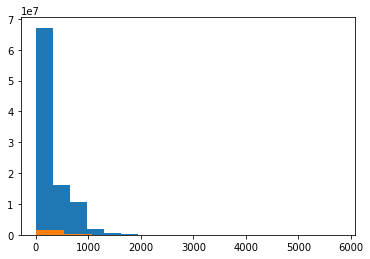

In [23]:
iskin, oskin = predictions(inp, out)

In [25]:
from skimage.metrics import structural_similarity
for i in range(len(iskin)):
    try:
        print(i)
#         skin_mask,After_annonymization_skin_mask = same_range(iscan[i], oscan[i])
#         score,diff = structural_similarity(np.array(skin_mask), np.array(After_annonymization_skin_mask), full=True)
#         print("scan score: ", score)
#         value = PSNR(np.array(skin_mask), np.array(After_annonymization_skin_mask ))
#         print(f"PSNR value for scann matched is {value} dB")
#         print("^^^^&&&&&^^^^")
        skin_mask,After_annonymization_skin_mask = same_range(iskin[i], oskin[i])
        score,diff = structural_similarity(np.array(skin_mask), np.array(After_annonymization_skin_mask), full=True)
        print("skin score: ", score)
        value = PSNR(np.array(skin_mask ), np.array(After_annonymization_skin_mask ))
        print(f"PSNR value for skin matched is {value} dB")
    except Exception as e:
        print("Error in i: ", e)
print("***************                                                   *****************")

0
skin score:  0.004546980656018572
PSNR value for skin matched is 9.461748982271441 dB
1
skin score:  0.002971866189937181
PSNR value for skin matched is 9.462556502493076 dB
2
skin score:  0.00010437458411215635
PSNR value for skin matched is 9.524488732233166 dB
3


/tmp/ipykernel_30516/1644663470.py:14: RuntimeWarning: invalid value encountered in true_divide
  imggdd = (imggr - min1) / (max1 - min1) * ((max_overall - min_overall) + min_overall)
/tmp/ipykernel_30516/1644663470.py:17: RuntimeWarning: invalid value encountered in true_divide
  imggff = (imggf - min2) / (max2 - min2) * ((max_overall - min_overall) + min_overall)


skin score:  nan
PSNR value for skin matched is nan dB
4
skin score:  0.0002701399110530459
PSNR value for skin matched is 9.484178085728974 dB
5
skin score:  0.00019699923070922793
PSNR value for skin matched is 9.530458278839106 dB
6
skin score:  0.0004454613704612351
PSNR value for skin matched is 9.524755073536484 dB
7
skin score:  0.00038855326297885156
PSNR value for skin matched is 9.523006603366515 dB
8
skin score:  2.96819591041003e-08
PSNR value for skin matched is 6.923007240617994 dB
9
skin score:  nan
PSNR value for skin matched is nan dB
10
skin score:  0.0009992532089155132
PSNR value for skin matched is 9.506336248217968 dB
11
skin score:  0.0002626955846557766
PSNR value for skin matched is 9.539261367676401 dB
***************                                                   *****************


In [11]:
ll = [r"/home/abdullah/mri_fa/MRI_DATA_HB/head/01034018/",
     r"/home/abdullah/mri_fa/MRI_DATA_HB/head/01218548/",
     r"/home/abdullah/mri_fa/MRI_DATA_HB/head/01457917/",
     r"/home/abdullah/mri_fa/MRI_DATA_HB/head/01456313/",
     r"/home/abdullah/mri_fa/MRI_DATA_HB/head/01291025/"]

In [12]:
opath = r"/home/minha/FARZEEN/face ann/face mri/output_temp/"

In [13]:
from math import log10, sqrt
import cv2
import numpy as np
  
def PSNR(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if(mse == 0):  # MSE is zero means no noise is present in the signal .
                  # Therefore PSNR have no importance.
        return 100
    max_pixel = np.max(original)#65536#np.max(np.sum(original)**2)
    psnr = 20 * log10(abs((max_pixel-1) / sqrt(mse)))
    return psnr

In [14]:
iskin, oskin, iscan, oscan = predictions(ll[0], opath)

in head


100%|███████████████████████████████████████████| 20/20 [00:51<00:00,  2.59s/it]

in AI 1613


In [19]:
from skimage.metrics import structural_similarity
for i in range(len(iskin)):
    try:
        print(i)
        skin_mask,After_annonymization_skin_mask = same_range(iscan[i], oscan[i])
        score,diff = structural_similarity(np.array(skin_mask), np.array(After_annonymization_skin_mask), full=True)
        print("scan: ", score)
    #     value = PSNR(np.array(skin_mask ), np.array(After_annonymization_skin_mask ))
    #     print(f"PSNR value for skin matched is {value} dB")
        print("^^^^&&&&&^^^^")
        skin_mask,After_annonymization_skin_mask = same_range(iskin[i], oskin[i])
        score,diff = structural_similarity(np.array(skin_mask), np.array(After_annonymization_skin_mask), full=True)
        print("skin: ", score)
    #     value = PSNR(np.array(skin_mask ), np.array(After_annonymization_skin_mask ))
    #     print(f"PSNR value for skin matched is {value} dB")
    except Exception as e:
        print("Error in i: ", e)
print("***************                                                   *****************")

0
scan:  1.0
^^^^&&&&&^^^^
skin:  0.0029101949853436414
1
scan:  1.0
^^^^&&&&&^^^^
skin:  0.00036357239212533307
2
scan:  1.0
^^^^&&&&&^^^^
skin:  0.0021856245911204383
3
scan:  1.0
^^^^&&&&&^^^^
Error in i:  win_size exceeds image extent. Either ensure that your images are at least 7x7; or pass win_size explicitly in the function call, with an odd value less than or equal to the smaller side of your images. If your images are multichannel (with color channels), set channel_axis to the axis number corresponding to the channels.
4
Error in i:  win_size exceeds image extent. Either ensure that your images are at least 7x7; or pass win_size explicitly in the function call, with an odd value less than or equal to the smaller side of your images. If your images are multichannel (with color channels), set channel_axis to the axis number corresponding to the channels.
5
scan:  1.0
^^^^&&&&&^^^^
skin:  0.0005786001529201841
6
scan:  1.0
^^^^&&&&&^^^^
skin:  0.002205985200267845
7
scan:  1.0
^^

In [5]:
def same_range(imggr, imggf):
    min1 = np.min(imggr)
    max1 = np.max(imggr)

    # Find min and max of image2
    min2 = np.min(imggf)
    max2 = np.max(imggf)

    # Find overall min and max
    min_overall = min(min1, min2)
    max_overall = max(max1, max2)

    # Scale image1 to the overall range
    imggdd = (imggr - min1) / (max1 - min1) * ((max_overall - min_overall) + min_overall)

    # Scale image2 to the overall range
    imggff = (imggf - min2) / (max2 - min2) * ((max_overall - min_overall) + min_overall)
    
#     maxi = np.max(imggdd)
#     imggdd = imggdd/1024
#     imggff = imggff/1024
    return imggdd, imggff

In [29]:
for l in ll:
    try:
        print(l)
        iskin, oskin, iscan, oscan = predictions(l, opath)
        for i in range(len(iskin)):
            print(i)
            
            skin_mask,After_annonymization_skin_mask = same_range(iskin[i], oskin[i])
            try:
                score,diff = structural_similarity(np.array(skin_mask), np.array(After_annonymization_skin_mask), full=True)
                print("skin: ", score)
            except Exception as e:
                print("error in: ", l, i)
                print(e)
            value = PSNR(np.array(skin_mask ), np.array(After_annonymization_skin_mask ))
            print(f"PSNR value for skin matched is {value} dB")
        print("***************                                                   *****************")
    except Exception as e:
        print("Error in: ",l)
        print(e)

/home/abdullah/mri_fa/MRI_DATA_HB/head/01034018/
in head


100%|███████████████████████████████████████████| 20/20 [00:52<00:00,  2.64s/it]


in AI 1613
0
skin:  0.002917973462407661
PSNR value for skin matched is 9.515732195197803 dB
1
skin:  0.0003473468947463492
PSNR value for skin matched is 9.460951610938377 dB
2
skin:  0.0022468160681337885
PSNR value for skin matched is 9.524347589960428 dB
3
error in:  /home/abdullah/mri_fa/MRI_DATA_HB/head/01034018/ 3
win_size exceeds image extent. Either ensure that your images are at least 7x7; or pass win_size explicitly in the function call, with an odd value less than or equal to the smaller side of your images. If your images are multichannel (with color channels), set channel_axis to the axis number corresponding to the channels.
PSNR value for skin matched is 9.52362107010427 dB
4
skin:  0.9132634420225282
PSNR value for skin matched is 15.320523363235171 dB
5
skin:  0.0005791981409904284
PSNR value for skin matched is 9.497372445557833 dB
6
skin:  0.002246637811559726
PSNR value for skin matched is 9.515321369756602 dB
7
skin:  0.0032389018099811323
PSNR value for skin matc

100%|███████████████████████████████████████████| 15/15 [00:25<00:00,  1.70s/it]


in AI 1126
0
skin:  0.0008239960666094133
PSNR value for skin matched is 9.48382755055326 dB
1
skin:  0.0018269118951092622
PSNR value for skin matched is 9.518221927804088 dB
2
skin:  0.0017706578960233377
PSNR value for skin matched is 9.523092677774835 dB
3
skin:  0.0020146150685795873
PSNR value for skin matched is 9.507645575069397 dB
4
skin:  0.9133092428701641
PSNR value for skin matched is 15.325036642599713 dB
5
skin:  0.0027785702814632613
PSNR value for skin matched is 9.523464327623389 dB
6
skin:  0.003310574681684737
PSNR value for skin matched is 9.504232591893176 dB
***************                                                   *****************
/home/abdullah/mri_fa/MRI_DATA_HB/head/01457917/
in head


100%|███████████████████████████████████████████| 19/19 [00:44<00:00,  2.37s/it]


in AI 1634
0
skin:  0.00044873485138557635
PSNR value for skin matched is 9.512540015062172 dB
1
skin:  0.0006909900444733456
PSNR value for skin matched is 9.476122911611775 dB
2
skin:  0.0017714455036438336
PSNR value for skin matched is 9.509101843159364 dB
3
skin:  0.0014208583224866393
PSNR value for skin matched is 9.52176947723257 dB
4
skin:  0.9161163790026073
PSNR value for skin matched is 15.558445239548984 dB
5
skin:  0.0026774310538977444
PSNR value for skin matched is 9.513439214197428 dB
6
skin:  0.002772691072696448
PSNR value for skin matched is 9.507974402566086 dB
7
skin:  0.0022748202213818637
PSNR value for skin matched is 9.513339831149956 dB
8
skin:  0.0028142603096515287
PSNR value for skin matched is 9.523853623314164 dB
9
skin:  0.003189655498542206
PSNR value for skin matched is 9.502054281294756 dB
10
skin:  0.0029025499758410993
PSNR value for skin matched is 9.5253067051946 dB
11
skin:  0.004831082454448193
PSNR value for skin matched is 9.506985277727313 d

100%|███████████████████████████████████████████| 20/20 [00:41<00:00,  2.07s/it]


in AI 1585
0
skin:  0.0006751138419942836
PSNR value for skin matched is 9.473425186762325 dB
1
skin:  0.0012383386880767734
PSNR value for skin matched is 9.511277351221832 dB
2
skin:  0.0011564151174912878
PSNR value for skin matched is 9.521822171612373 dB
3
skin:  0.9133394477081741
PSNR value for skin matched is 15.321898161420858 dB
4
skin:  0.002118026081604652
PSNR value for skin matched is 9.513899587139825 dB
5
skin:  0.0020953309925066618
PSNR value for skin matched is 9.506718420428914 dB
6
skin:  0.0013309932091691342
PSNR value for skin matched is 9.517488881737634 dB
7
skin:  0.0028890424731978738
PSNR value for skin matched is 9.523457970041257 dB
8
skin:  0.004188367910710346
PSNR value for skin matched is 9.498501969056313 dB
9
skin:  0.002943509027063516
PSNR value for skin matched is 9.525125927683213 dB
10
skin:  0.005128636045967504
PSNR value for skin matched is 9.502544657301122 dB
***************                                                   ***************

100%|███████████████████████████████████████████| 14/14 [00:42<00:00,  3.03s/it]


in AI 1095
0
skin:  0.0024134307418384646
PSNR value for skin matched is 9.515613012469302 dB
1
skin:  0.0015787381630355981
PSNR value for skin matched is 9.511302352441511 dB
2
skin:  0.000512380033000309
PSNR value for skin matched is 9.463602724728268 dB
3
skin:  0.001541987639347774
PSNR value for skin matched is 9.5196528152936 dB
4
skin:  0.0020574121546167554
PSNR value for skin matched is 9.502709741733984 dB
5
skin:  0.9147427863807525
PSNR value for skin matched is 15.45671837289959 dB
6
skin:  0.0021035345797092357
PSNR value for skin matched is 9.517757863719003 dB
7
skin:  0.003016193023178673
PSNR value for skin matched is 9.520580962799098 dB
8
skin:  0.0034721627378724246
PSNR value for skin matched is 9.503082406664323 dB
***************                                                   *****************


In [28]:
for l in ll:
    try:
        print(l)
        iskin, oskin, iscan, oscan = predictions(l, opath)
        for i in range(len(iskin)):
            print(i)
            skin_mask,After_annonymization_skin_mask = same_range(iskin[i], oskin[i])
            score,diff = structural_similarity(np.array(skin_mask), np.array(After_annonymization_skin_mask), full=True)
            print("skin: ", score)
            value = PSNR(np.array(skin_mask ), np.array(After_annonymization_skin_mask ))
            print(f"PSNR value for skin matched is {value} dB")
        print("***************                                                   *****************")
    except Exception as e:
        print("Error in: ",l)
        print(e)

/home/abdullah/mri_fa/MRI_DATA_HB/head/01034018/
in head


100%|███████████████████████████████████████████| 20/20 [00:52<00:00,  2.63s/it]


in AI 1613
0
skin:  0.0029200900675219513
PSNR value for skin matched is 9.515778887903775 dB
1
skin:  0.00035569271790393607
PSNR value for skin matched is 9.461629503554235 dB
2
skin:  0.002216895174538971
PSNR value for skin matched is 9.524706099401449 dB
3
Error in:  /home/abdullah/mri_fa/MRI_DATA_HB/head/01034018/
win_size exceeds image extent. Either ensure that your images are at least 7x7; or pass win_size explicitly in the function call, with an odd value less than or equal to the smaller side of your images. If your images are multichannel (with color channels), set channel_axis to the axis number corresponding to the channels.
/home/abdullah/mri_fa/MRI_DATA_HB/head/01218548/
in head


100%|███████████████████████████████████████████| 15/15 [00:25<00:00,  1.72s/it]


in AI 1126
0
skin:  0.0007096936806256308
PSNR value for skin matched is 9.48406801260436 dB
1
skin:  0.0018414989512809568
PSNR value for skin matched is 9.518010981876262 dB
2
skin:  0.001739328078849917
PSNR value for skin matched is 9.523444878626728 dB
3
skin:  0.001971534917944941
PSNR value for skin matched is 9.50755905270109 dB
4
skin:  0.913228091176621
PSNR value for skin matched is 15.324276784068065 dB
5
skin:  0.002798351045780832
PSNR value for skin matched is 9.522986330119402 dB
6
skin:  0.0033475239393385256
PSNR value for skin matched is 9.50412738123227 dB
***************                                                   *****************
/home/abdullah/mri_fa/MRI_DATA_HB/head/01457917/
in head


100%|███████████████████████████████████████████| 19/19 [00:45<00:00,  2.38s/it]


in AI 1634
0
skin:  0.00046737408432631964
PSNR value for skin matched is 9.513062521932607 dB
1
skin:  0.0007053264706566955
PSNR value for skin matched is 9.477874407164993 dB
2
skin:  0.0017875420071338816
PSNR value for skin matched is 9.50954201388513 dB
3
skin:  0.0014148494320006505
PSNR value for skin matched is 9.521876938891936 dB
4
skin:  0.9161196809004348
PSNR value for skin matched is 15.558206998147881 dB
5
skin:  0.002668663119873025
PSNR value for skin matched is 9.512963065606858 dB
6
skin:  0.002655733727824255
PSNR value for skin matched is 9.507785874870262 dB
7
skin:  0.0022307816235730923
PSNR value for skin matched is 9.513431197520191 dB
8
skin:  0.002832274594910082
PSNR value for skin matched is 9.524121533754409 dB
9
skin:  0.0032356369148275814
PSNR value for skin matched is 9.50258715317287 dB
10
skin:  0.002902639217839115
PSNR value for skin matched is 9.52506419545231 dB
11
skin:  0.004763135909412567
PSNR value for skin matched is 9.507577081421067 dB


100%|███████████████████████████████████████████| 20/20 [00:42<00:00,  2.11s/it]


in AI 1585
0
skin:  0.000648409380518898
PSNR value for skin matched is 9.47546790494798 dB
1
skin:  0.0012486748505302345
PSNR value for skin matched is 9.510901778994786 dB
2
skin:  0.0011424767506731817
PSNR value for skin matched is 9.521832963054678 dB
3
skin:  0.913298839752537
PSNR value for skin matched is 15.318842169861249 dB
4
skin:  0.0021165785893714774
PSNR value for skin matched is 9.514033907677817 dB
5
skin:  0.001994823282175785
PSNR value for skin matched is 9.50761467537697 dB
6
skin:  0.0012356922391167672
PSNR value for skin matched is 9.517208776063539 dB
7
skin:  0.002882695348869847
PSNR value for skin matched is 9.523374215590048 dB
8
skin:  0.004163707890179822
PSNR value for skin matched is 9.498328348372318 dB
9
skin:  0.002965294245275722
PSNR value for skin matched is 9.524646076028432 dB
10
skin:  0.005060855412529234
PSNR value for skin matched is 9.502542385586183 dB
***************                                                   *****************
/h

100%|███████████████████████████████████████████| 14/14 [00:42<00:00,  3.06s/it]


in AI 1095
0
skin:  0.0024147499448781626
PSNR value for skin matched is 9.515461011118841 dB
1
skin:  0.001604179233570295
PSNR value for skin matched is 9.51123672928826 dB
2
skin:  0.0004486038660292632
PSNR value for skin matched is 9.464794576524485 dB
3
skin:  0.0015171633465867332
PSNR value for skin matched is 9.519782857939642 dB
4
skin:  0.0020347974912286325
PSNR value for skin matched is 9.503151724179727 dB
5
skin:  0.914752094709417
PSNR value for skin matched is 15.458782253811144 dB
6
skin:  0.0020826882215212897
PSNR value for skin matched is 9.517761257723727 dB
7
skin:  0.0030316289554454135
PSNR value for skin matched is 9.520170451002555 dB
8
skin:  0.003494309732756168
PSNR value for skin matched is 9.502842520506459 dB
***************                                                   *****************


In [ ]:
ipath = r"/home/abdullah/mri_fa/MRI_DATA_HB/brain/20392703/" #20392703
opath = r"/home/minha/FARZEEN/face ann/face mri/output_brain/20392703/"